In [76]:
import time
start = time.perf_counter()

In [77]:
import pandas as pd
import numpy as np
%matplotlib inline
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score,  GridSearchCV, StratifiedShuffleSplit, learning_curve, validation_curve, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, confusion_matrix, roc_curve, roc_auc_score, recall_score, f1_score, classification_report, precision_score, homogeneity_score, normalized_mutual_info_score, davies_bouldin_score, mean_squared_error, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
import seaborn as sns
from kmodes.kmodes import KModes
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [12]:
np.random.seed(903967645)

In [ ]:
# Increase font sizes
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 12

### Preprocess Data

In [13]:
phishing_dataset = pd.read_csv('../data/phishing_dataset.csv')
print(phishing_dataset.info())
phishing_dataset.drop(columns=['index'], inplace=True)
phishing_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [14]:
# Check shape of dataset and for null data
print(phishing_dataset.shape)
phishing_dataset.isna().any().any()

(11055, 31)


False

In [15]:
print(phishing_dataset.columns)

Index(['having_IPhaving_IP_Address', 'URLURL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')


In [36]:
# Separate features and target
phishing_dataset = phishing_dataset.sample(frac=0.1, random_state=42)
print(phishing_dataset.shape)

train_X = phishing_dataset.drop(columns=['Result', 'Favicon', 'Shortining_Service', 'popUpWidnow', 'double_slash_redirecting'])
train_y = phishing_dataset['Result']

# Normalize the feature data
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(train_X)

# Convert back to DataFrame
train_X = pd.DataFrame(X_scaled, columns=train_X.columns)

(111, 31)


In [37]:
def add_jitter(column, noise_level=0.1):
    return column + np.random.normal(0, noise_level, column.shape)

train_X_jittered = train_X.copy()
for col in features_to_plot + features_to_plot_3d:
    train_X_jittered[col] = add_jitter(train_X[col])

In [38]:
print(f"Rank of Phishing dataset: {np.linalg.matrix_rank(train_X)}")

Rank of Phishing dataset: 26


In [39]:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

vif_results = calculate_vif(train_X)
print(f"Average VIF: {vif_results['VIF'].mean()}")
print(vif_results)
print(vif_results.head(10))

Average VIF: 12.842878216502669
                        feature        VIF
18                       Iframe  60.379840
17                   RightClick  44.556597
7                          port  36.478175
16                 on_mouseover  33.313332
13          Submitting_to_email  23.866192
8                   HTTPS_token  17.600884
14                 Abnormal_URL  14.566577
2              having_At_Symbol  14.106091
25           Statistical_report  10.867407
23                 Google_Index  10.349005
24       Links_pointing_to_page   7.507648
20                    DNSRecord   6.679862
10                URL_of_Anchor   6.289229
21                  web_traffic   6.082246
0    having_IPhaving_IP_Address   6.020087
5                SSLfinal_State   5.950707
9                   Request_URL   5.511681
4             having_Sub_Domain   4.070737
19                age_of_domain   3.482639
11                Links_in_tags   3.086072
1                 URLURL_Length   2.529582
6   Domain_registerati

In [40]:
correlation_matrix = train_X.corr()
print(correlation_matrix)

                             having_IPhaving_IP_Address  URLURL_Length  \
having_IPhaving_IP_Address                     1.000000       0.004594   
URLURL_Length                                  0.004594       1.000000   
having_At_Symbol                               0.298905      -0.063336   
Prefix_Suffix                                 -0.267810       0.011023   
having_Sub_Domain                             -0.117422       0.041534   
SSLfinal_State                                 0.042017       0.131632   
Domain_registeration_length                    0.009074      -0.254188   
port                                           0.034437       0.027945   
HTTPS_token                                    0.185475       0.002676   
Request_URL                                    0.000736       0.342570   
URL_of_Anchor                                  0.069396      -0.027800   
Links_in_tags                                  0.045580      -0.017195   
SFH                                   

## Clustering

### K-Modes

In [117]:
%%time
# davies_bouldin_scores_KM = {}
# adjusted_rand_scores_KM = {}
# homogeneity_scores_KM = {}
costs_KM = {}

for cluster in range(2, 31, 1):
    kmodes = KModes(n_clusters=cluster, init='Huang', n_init=50, max_iter=1000, random_state=42).fit(train_X)
    label = kmodes.labels_
    
    # db_score = davies_bouldin_score(train_X, label)
    # ari_score = adjusted_rand_score(train_y, label)
    # homog_score = homogeneity_score(train_y, label)
    cost = kmodes.cost_

    
    # davies_bouldin_scores_KM[cluster] = db_score
    # adjusted_rand_scores_KM[cluster] = ari_score
    # homogeneity_scores_KM[cluster] = homog_score
    costs_KM[cluster] = cost

    
    # print(f"For n_clusters={cluster}, The Davies-Bouldin Index is {db_score}")
    # print(f"For n_clusters={cluster}, The Adjusted Rand Index is {ari_score}")
    # print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    print(f"For n_clusters={cluster}, The cost is {cost}")


# # Plotting Davies-Bouldin Index
# plt.figure(figsize=(10, 6))
# plt.plot(list(davies_bouldin_scores_KM.keys()), list(davies_bouldin_scores_KM.values()), marker='o')
# plt.xlabel("Number of Clusters")
# plt.ylabel("Davies-Bouldin Index")
# plt.title("K-Modes - Davies-Bouldin Index for Various Numbers of Clusters (Phishing)")
# plt.grid(True)
# plt.savefig('../images/phishing-kmodes-davies-bouldin-index.png')
# plt.show()

# # Plotting Adjusted Rand Index
# plt.figure(figsize=(10, 6))
# plt.plot(list(adjusted_rand_scores_KM.keys()), list(adjusted_rand_scores_KM.values()), marker='o', color='g')
# plt.xlabel("Number of Clusters")
# plt.ylabel("Adjusted Rand Index")
# plt.title("K-Modes - Adjusted Rand Index for Various Numbers of Clusters (Phishing)")
# plt.grid(True)
# plt.savefig('../images/phishing-kmodes-adjusted-rand-index.png')
# plt.show()

# # Plotting Homogeneity Score
# plt.figure(figsize=(10, 6))
# plt.plot(list(homogeneity_scores_KM.keys()), list(homogeneity_scores_KM.values()), marker='o', color='r')
# plt.xlabel("Number of Clusters")
# plt.ylabel("Homogeneity Score")
# plt.title("K-Modes - Homogeneity Score for Various Numbers of Clusters (Phishing)")
# plt.grid(True)
# plt.savefig('../images/phishing-kmodes-homogeneity.png')
# plt.show()

# # Plotting Davies-Bouldin Index, Adjusted Rand Index, and Homogeneity Score together
# plt.figure(figsize=(10, 6))
# plt.plot(list(davies_bouldin_scores_KM.keys()), list(davies_bouldin_scores_KM.values()), 'b', label='Davies-Bouldin Index', marker='o')
# plt.plot(list(adjusted_rand_scores_KM.keys()), list(adjusted_rand_scores_KM.values()), 'g', label='Adjusted Rand Index', marker='x')
# plt.plot(list(homogeneity_scores_KM.keys()), list(homogeneity_scores_KM.values()), 'r', label='Homogeneity Score', marker='^')
# plt.legend(loc='best')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Score')
# plt.title('K-Modes - Clustering Evaluation Metrics for Various Numbers of Clusters (Phishing)')
# plt.grid(True)
# plt.savefig('../images/phishing-kmodes-clustering-metrics.png')
# plt.show()

plt.figure(8,6)
plt.plot(list(costs_KM.keys()), list(costs_KM.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Cost")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.savefig('../images/phishing-elbow-cost.png')
plt.show()

For n_clusters=2, The cost is 829.0
For n_clusters=3, The cost is 749.0
For n_clusters=4, The cost is 698.0
For n_clusters=5, The cost is 657.0
For n_clusters=6, The cost is 619.0
For n_clusters=7, The cost is 595.0
For n_clusters=8, The cost is 568.0
For n_clusters=9, The cost is 551.0
For n_clusters=10, The cost is 528.0
For n_clusters=11, The cost is 498.0
For n_clusters=12, The cost is 489.0
For n_clusters=13, The cost is 490.0
For n_clusters=14, The cost is 475.0
For n_clusters=15, The cost is 455.0
For n_clusters=16, The cost is 455.0
For n_clusters=17, The cost is 446.0
For n_clusters=18, The cost is 439.0
For n_clusters=19, The cost is 430.0
For n_clusters=20, The cost is 433.0
For n_clusters=21, The cost is 415.0
For n_clusters=22, The cost is 408.0
For n_clusters=23, The cost is 407.0
For n_clusters=24, The cost is 394.0
For n_clusters=25, The cost is 399.0
For n_clusters=26, The cost is 391.0
For n_clusters=27, The cost is 378.0
For n_clusters=28, The cost is 376.0
For n_clu

TypeError: Value after * must be an iterable, not int

In [41]:
optimal_cluster = 6
kmodes = KModes(n_clusters=optimal_cluster, init='Huang', n_init=5, verbose=1)
clusters = kmodes.fit_predict(train_X)
kmodes_labels = kmodes.labels_

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 30, cost: 557.0
Run 1, iteration: 2/100, moves: 9, cost: 557.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 27, cost: 578.0
Run 2, iteration: 2/100, moves: 18, cost: 566.0
Run 2, iteration: 3/100, moves: 2, cost: 566.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 23, cost: 570.0
Run 3, iteration: 2/100, moves: 18, cost: 557.0
Run 3, iteration: 3/100, moves: 5, cost: 557.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 30, cost: 568.0
Run 4, iteration: 2/100, moves: 6, cost: 564.0
Run 4, iteration: 3/100, moves: 1, cost: 564.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 24, cost: 571.0
Run 5, iteration: 2/100, move

In [42]:
train_X['KModes_Cluster'] = kmodes_labels

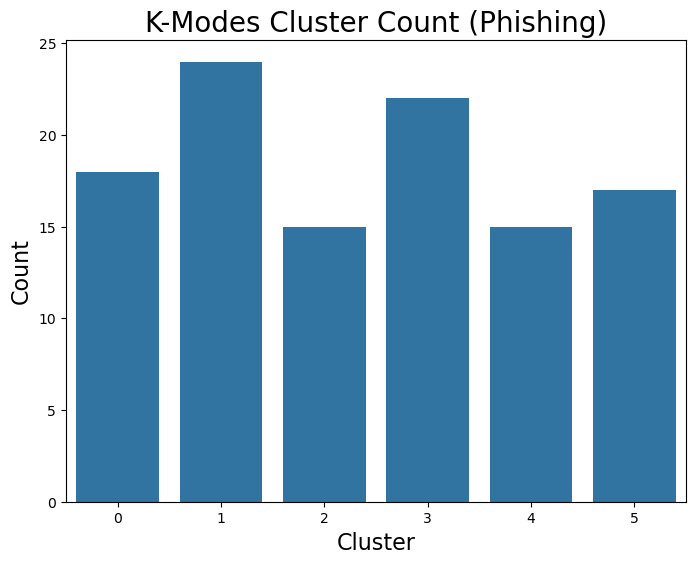

In [118]:
# Cluster count bar plot for K-modes
plt.figure(figsize=(8, 6))
sns.countplot(x=train_X['KModes_Cluster'])
plt.title('K-Modes Cluster Count (Phishing)', fontsize=20)
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('../images/phishing-kmodes-cluster-count.png')
plt.show()

In [44]:
# Check if clusters align with the classes
accuracy_score((1-kmodes.labels_),train_y)

0.018018018018018018

In [45]:
adjusted_mutual_info_score((kmodes.labels_ + 1), train_y)

0.23097224773002964

### Expectation Maximization

For n_clusters=2, The Silhouette Coefficient is 0.07770750714561575
For n_clusters=2, The homogeneity_score is 0.0358628431753279
For n_clusters=2, The log_likelihood is 6.456667204311167
For n_clusters=3, The Silhouette Coefficient is 0.3413392583635418
For n_clusters=3, The homogeneity_score is 0.05206400639953499
For n_clusters=3, The log_likelihood is 11.34167634255664
For n_clusters=4, The Silhouette Coefficient is 0.28512013716284196
For n_clusters=4, The homogeneity_score is 0.13161111935449274
For n_clusters=4, The log_likelihood is 25.23467352164327
For n_clusters=5, The Silhouette Coefficient is 0.2335976474407642
For n_clusters=5, The homogeneity_score is 0.0650939552660594
For n_clusters=5, The log_likelihood is 38.178153507398555
For n_clusters=6, The Silhouette Coefficient is 0.22978046348424164
For n_clusters=6, The homogeneity_score is 0.20562281015296707
For n_clusters=6, The log_likelihood is 55.09383960694232
For n_clusters=7, The Silhouette Coefficient is 0.21068731

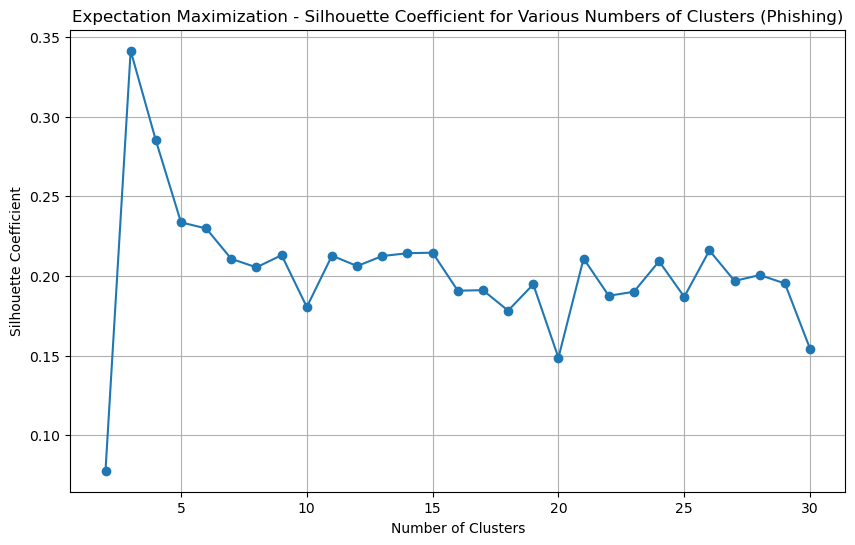

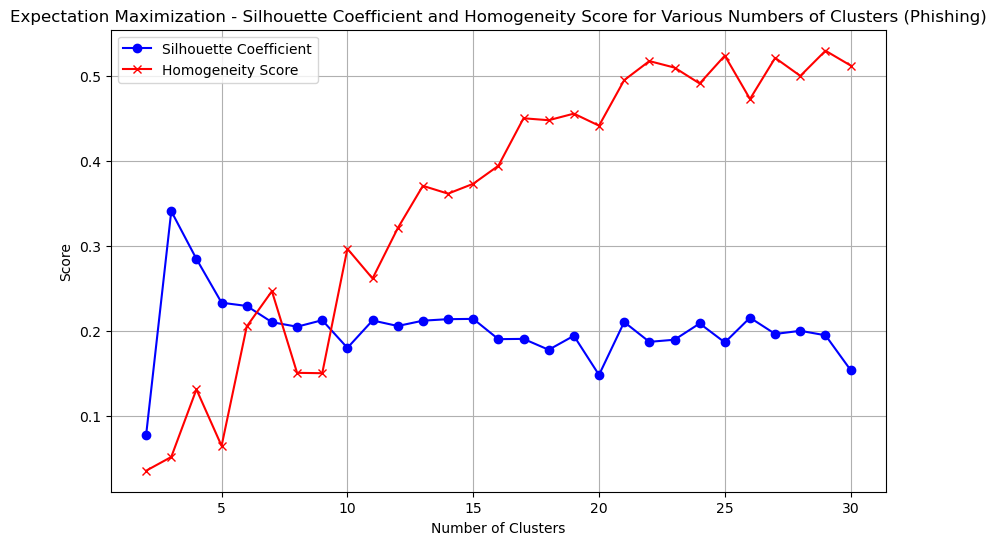

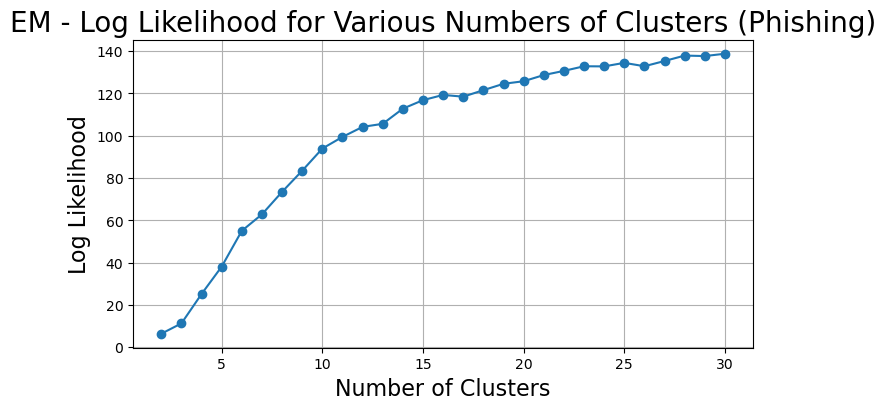

In [111]:
silhouette_coeffs_EM = {}
homogeneity_scores_EM = {}
log_likelihood_EM = {}

for cluster in range(2, 31, 1):
    gmm = GaussianMixture(n_components=cluster, n_init=10, max_iter=50, random_state=42).fit(train_X)
    label = gmm.predict(train_X)
    sil_coeff = silhouette_score(train_X, label, metric='euclidean')
    homog_score = homogeneity_score(train_y, label)
    log = gmm.score(train_X)
    
    silhouette_coeffs_EM[cluster] = sil_coeff
    homogeneity_scores_EM[cluster] = homog_score
    log_likelihood_EM[cluster] = log
    print(f"For n_clusters={cluster}, The Silhouette Coefficient is {sil_coeff}")
    print(f"For n_clusters={cluster}, The homogeneity_score is {homog_score}")
    print(f"For n_clusters={cluster}, The log_likelihood is {log}")

    
# Plotting Silhouette Coefficients
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.title("EM - Silhouette Coefficient for Various Numbers of Clusters (Phishing)")
plt.grid(True)
plt.savefig('../images/phishing-em-silhoueete-coefficients.png')
plt.show()

# Plotting Silhouette Coefficient and Homogeneity Score
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_coeffs_EM.keys()), list(silhouette_coeffs_EM.values()), 'b', label='Silhouette Coefficient', marker='o')
plt.plot(list(homogeneity_scores_EM.keys()), list(homogeneity_scores_EM.values()), 'r', label='Homogeneity Score', marker='x')
plt.legend(loc='best')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('EM - Silhouette Coefficient and Homogeneity Score for Various Numbers of Clusters (Phishing)')
plt.grid(True)
plt.savefig('../images/phishing-em-sihouette-and-homogeneity.png')
plt.show()

# Plotting Log Likelihood
plt.figure(figsize=(8, 4))
plt.plot(list(log_likelihood_EM.keys()), list(log_likelihood_EM.values()), marker='o')
plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Log Likelihood", fontsize=16)
plt.title("EM - Log Likelihood for Various Numbers of Clusters (Phishing)", fontsize=20)
plt.grid(True)
plt.savefig('../images/phishing-em-log-likelihood.png')
plt.show()

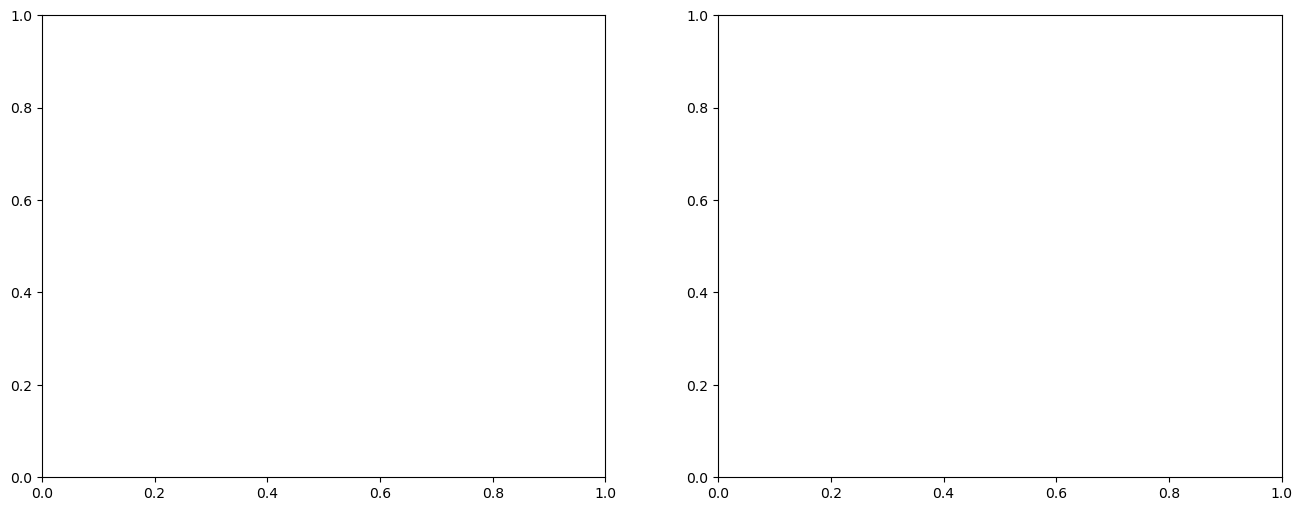

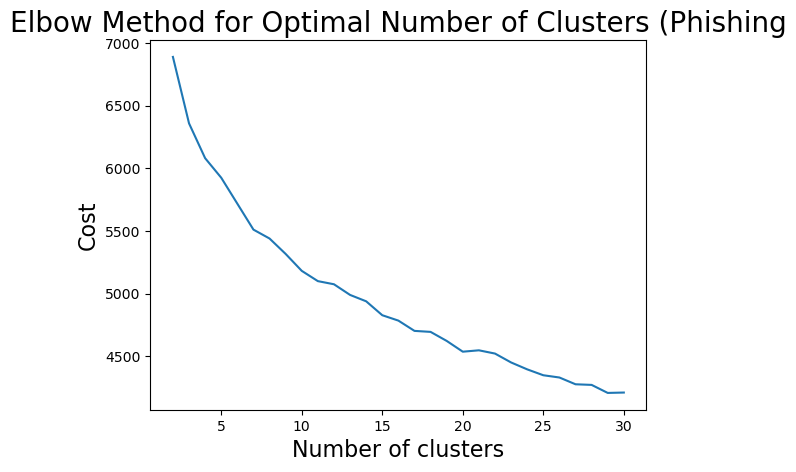

<Figure size 640x480 with 0 Axes>

In [106]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.figure()
plt.plot(list(costs_KM.keys()), list(costs_KM.values()))
plt.xlabel("Number of clusters", fontsize=16)
plt.ylabel("Cost", fontsize=16)
plt.title("Elbow Method for Optimal Number of Clusters (Phishing", fontsize=20)
plt.savefig('../images/phishing-elbow-cost.png')
plt.show()

# Plot Cost (K-modes) on the right subplot
ax2.plot(list(costs_KM.keys()), list(costs_KM.values()))
ax2.set_xlabel("Number of clusters", fontsize=16)
ax2.set_ylabel("Cost", fontsize=16)
ax2.set_title("Elbow Method for K-modes (Phishing)", fontsize=20)

# Adjust the layout and add a main title
plt.tight_layout()
fig.suptitle("Elbow Methods for Optimal Number of Clusters", fontsize=20)
plt.subplots_adjust(top=0.88)  # Adjust top margin to accommodate the main title

# Save the figure
plt.savefig('../images/combined_elbow_methods.png')

# Show the plot
plt.show()

In [50]:
optimal_cluster = 10
gmm = GaussianMixture(n_components=optimal_cluster, random_state=42)
gmm.fit(train_X.drop(columns=['KModes_Cluster']))
gmm_labels = gmm.predict(train_X.drop(columns=['KModes_Cluster']))

In [51]:
train_X['GMM_Cluster'] = gmm_labels

#### Plots

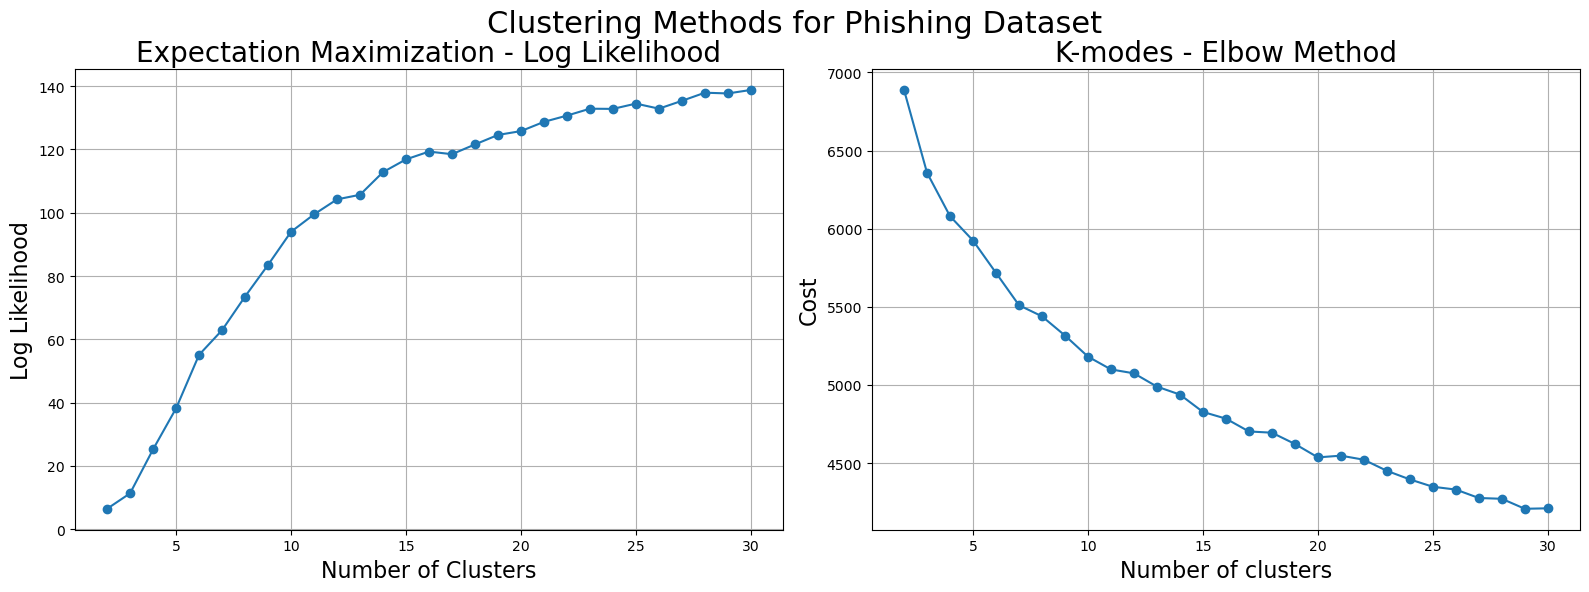

In [107]:
# Set a base font size
base_font_size = 14
title_font_size = 20
legend_font_size = 16
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Log Likelihood (EM) on the left subplot
ax1.plot(list(log_likelihood_EM.keys()), list(log_likelihood_EM.values()), marker='o')
ax1.set_xlabel("Number of Clusters", fontsize=16)
ax1.set_ylabel("Log Likelihood", fontsize=16)
ax1.set_title("Expectation Maximization - Log Likelihood", fontsize=20)
ax1.grid(True)

# Plot Cost (K-modes) on the right subplot
ax2.plot(list(costs_KM.keys()), list(costs_KM.values()), marker='o')
ax2.set_xlabel("Number of clusters", fontsize=16)
ax2.set_ylabel("Cost", fontsize=16)
ax2.set_title("K-modes - Elbow Method", fontsize=20)
ax2.grid(True)

# Adjust the layout and add a main title
plt.tight_layout()
fig.suptitle("Clustering Methods for Phishing Dataset", fontsize=22)
plt.subplots_adjust(top=0.88)  # Adjust top margin to accommodate the main title

# Save the figure
plt.savefig('../images/phishing_combined_clustering_methods.png')

# Show the plot
plt.show()

In [53]:
print(train_X.head())

   having_IPhaving_IP_Address  URLURL_Length  having_At_Symbol  Prefix_Suffix  \
0                         1.0            0.0               1.0            0.0   
1                         1.0            0.0               0.0            0.0   
2                         0.0            0.0               0.0            1.0   
3                         0.0            0.0               1.0            0.0   
4                         1.0            0.0               1.0            0.0   

   having_Sub_Domain  SSLfinal_State  Domain_registeration_length  port  \
0                1.0             1.0                          0.0   1.0   
1                1.0             1.0                          0.0   0.0   
2                1.0             1.0                          0.0   0.0   
3                0.0             0.0                          0.0   0.0   
4                1.0             1.0                          0.0   1.0   

   HTTPS_token  Request_URL  ...  Iframe  age_of_domain  DNSRe

In [54]:
features_to_plot = ['having_IPhaving_IP_Address', 'Page_Rank']
# Get unique clusters for KModes and GMM
unique_clusters_kmodes = np.unique(train_X['KModes_Cluster'])
unique_clusters_gmm = np.unique(train_X['GMM_Cluster'])

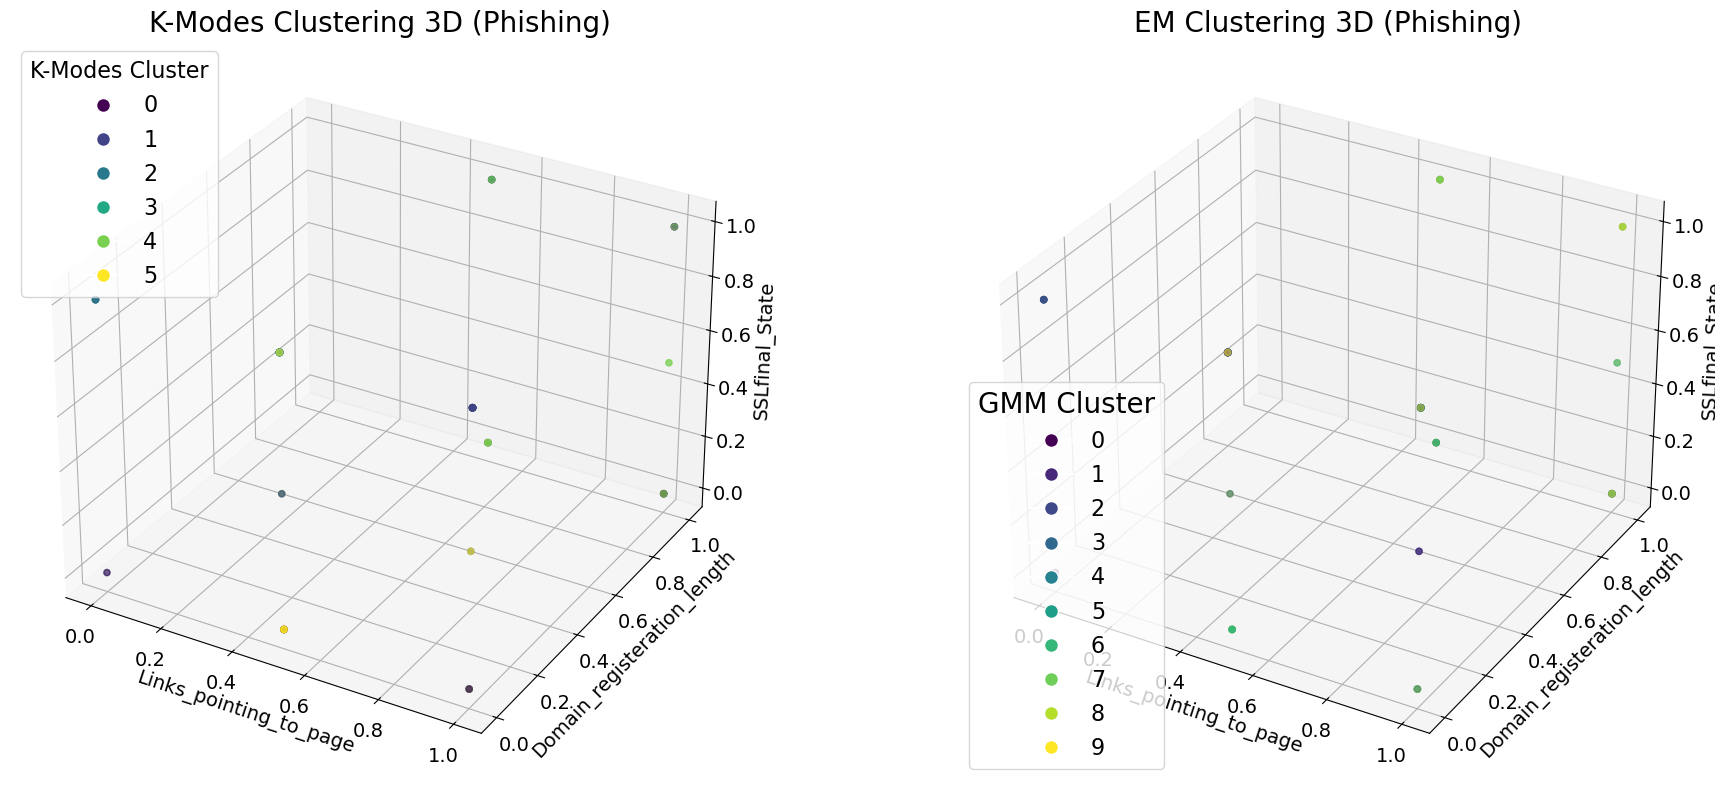

In [108]:
# Define the features you want to plot
features_to_plot_2d = ['Links_pointing_to_page', 'Domain_registeration_length']
features_to_plot_3d = ['Links_pointing_to_page', 'Domain_registeration_length', 'SSLfinal_State']
# Set a base font size
base_font_size = 14
title_font_size = 20
legend_font_size = 16

# Create a figure for 2D plots
fig_2d = plt.figure(figsize=(20, 8))

# 2D Plot for K-Modes clustering results
ax1 = fig_2d.add_subplot(121)
scatter_kmodes = ax1.scatter(train_X[features_to_plot_2d[0]], train_X[features_to_plot_2d[1]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
ax1.set_title('K-Modes Clustering 2D (Phishing)')
ax1.set_xlabel(features_to_plot_2d[0])
ax1.set_ylabel(features_to_plot_2d[1])
handles_kmodes = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_kmodes.cmap(scatter_kmodes.norm(cluster)), markersize=10) for cluster in unique_clusters_kmodes]
ax1.legend(handles_kmodes, unique_clusters_kmodes, title='K-Modes Cluster', loc='best')

# 2D Plot for GMM clustering results
ax2 = fig_2d.add_subplot(122)
scatter_gmm = ax2.scatter(train_X[features_to_plot_2d[0]], train_X[features_to_plot_2d[1]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax2.set_title('EM Clustering 2D (Phishing)')
ax2.set_xlabel(features_to_plot_2d[0])
ax2.set_ylabel(features_to_plot_2d[1])
handles_gmm = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter_gmm.cmap(scatter_gmm.norm(cluster)), markersize=10) for cluster in unique_clusters_gmm]
ax2.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best')

# Adjust layout and save the 2D plots
plt.tight_layout()
plt.savefig('../images/phishing-clustering-comparison-2D.png')
plt.close(fig_2d)

# Create a figure for 3D plots
fig_3d = plt.figure(figsize=(20, 8))

# 3D Plot for K-Modes clustering results
ax3 = fig_3d.add_subplot(121, projection='3d')
scatter_kmodes_3d = ax3.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['KModes_Cluster'], cmap='viridis', alpha=0.5)
ax3.set_title('K-Modes Clustering 3D (Phishing)', fontsize=title_font_size)
ax3.set_xlabel(features_to_plot_3d[0], fontsize=base_font_size)
ax3.set_ylabel(features_to_plot_3d[1], fontsize=base_font_size)
ax3.set_zlabel(features_to_plot_3d[2], fontsize=base_font_size)
ax3.legend(handles_kmodes, unique_clusters_kmodes, title='K-Modes Cluster', loc='best', fontsize=legend_font_size, title_fontsize=legend_font_size)

# Increase tick label font size
ax3.tick_params(axis='both', which='major', labelsize=base_font_size)

# 3D Plot for GMM clustering results
ax4 = fig_3d.add_subplot(122, projection='3d')
scatter_gmm_3d = ax4.scatter(train_X[features_to_plot_3d[0]], train_X[features_to_plot_3d[1]], train_X[features_to_plot_3d[2]], c=train_X['GMM_Cluster'], cmap='viridis', alpha=0.5)
ax4.set_title('EM Clustering 3D (Phishing)', fontsize=title_font_size)
ax4.set_xlabel(features_to_plot_3d[0], fontsize=base_font_size)
ax4.set_ylabel(features_to_plot_3d[1], fontsize=base_font_size)
ax4.set_zlabel(features_to_plot_3d[2], fontsize=base_font_size)
ax4.legend(handles_gmm, unique_clusters_gmm, title='GMM Cluster', loc='best', fontsize=legend_font_size, title_fontsize=title_font_size)

# Increase tick label font size
ax4.tick_params(axis='both', which='major', labelsize=base_font_size)

# Adjust layout and save the 3D plots
plt.tight_layout()
plt.savefig('../images/phishing-clustering-comparison-3D.png', dpi=300)
plt.show(fig_3d)

In [58]:
# Calculate ARI
ari_score = adjusted_rand_score(train_X['KModes_Cluster'], train_X['GMM_Cluster'])
print(f'Adjusted Rand Index (ARI) between KModes and GMM clusters: {ari_score}')

# Calculate NMI
nmi_score = normalized_mutual_info_score(train_X['KModes_Cluster'], train_X['GMM_Cluster'])
print(f'Normalized Mutual Information (NMI) between KModes and GMM clusters: {nmi_score}')

Adjusted Rand Index (ARI) between KModes and GMM clusters: 0.16873808048889136
Normalized Mutual Information (NMI) between KModes and GMM clusters: 0.36100356901374525


# Neural Networks

### K-Modes

In [67]:
# Ensure train_X_grp and train_y are pandas DataFrames/Series
train_X_kmodes = pd.DataFrame(kmodes_labels)
train_y_kmodes = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(train_X_kmodes, train_y_kmodes):
    strat_train_set_kmodes = train_X_kmodes.iloc[train_index]
    strat_test_set_kmodes = train_X_kmodes.iloc[test_index]
    strat_train_labels_kmodes = train_y_kmodes.iloc[train_index]
    strat_test_labels_kmodes = train_y_kmodes.iloc[test_index]

train_X_kmodes = strat_train_set_kmodes
test_X_kmodes = strat_test_set_kmodes
train_y_kmodes = strat_train_labels_kmodes
test_y_kmodes = strat_test_labels_kmodes

In [68]:
neural_net_kmodes = MLPClassifier(random_state=42)
neural_net_kmodes.fit(train_X_kmodes, train_y_kmodes)

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

In [69]:
%%time
# Evaluate on training data
train_predictions_kmodes = neural_net_kmodes.predict(train_X_kmodes)
train_accuracy_kmodes = accuracy_score(train_y_kmodes, train_predictions_kmodes)
train_roc_auc_kmodes = roc_auc_score(train_y_kmodes, train_predictions_kmodes)
train_precision_kmodes = precision_score(train_y_kmodes, train_predictions_kmodes)
train_recall_kmodes = recall_score(train_y_kmodes, train_predictions_kmodes)
train_f1_kmodes = f1_score(train_y_kmodes, train_predictions_kmodes)

print("Training Accuracy K-Modes:", train_accuracy_kmodes)
print("Training ROC AUC Score K-Modes:", train_roc_auc_kmodes)
print("Training Precision K-Modes:", train_precision_kmodes)
print("Training Recall K-Modes:", train_recall_kmodes)
print("Training F1 Score K-Modes:", train_f1_kmodes)
train_report_kmodes = classification_report(train_y_kmodes, train_predictions_kmodes)
print(train_report_kmodes)

# Write to a text file
with open('../results/phishing-nn-kmodes-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy K-Modes: " + str(train_accuracy_kmodes) + "\n")
    file.write("Training ROC AUC Score K-Modes: " + str(train_roc_auc_kmodes) + "\n")
    file.write("Training Precision K-Modes: " + str(train_precision_kmodes) + "\n")
    file.write("Training Recall K-Modes: " + str(train_recall_kmodes) + "\n")
    file.write("Training F1 Score K-Modes: " + str(train_f1_kmodes) + "\n")
    file.write("\nClassification Report K-Modes:\n")
    file.write(train_report_kmodes + "\n")

Training Accuracy K-Modes: 0.7272727272727273
Training ROC AUC Score K-Modes: 0.6666666666666667
Training Precision K-Modes: 0.6842105263157895
Training Recall K-Modes: 1.0
Training F1 Score K-Modes: 0.8125
              precision    recall  f1-score   support

          -1       1.00      0.33      0.50        36
           1       0.68      1.00      0.81        52

    accuracy                           0.73        88
   macro avg       0.84      0.67      0.66        88
weighted avg       0.81      0.73      0.68        88

CPU times: user 11.3 ms, sys: 3.89 ms, total: 15.2 ms
Wall time: 12.7 ms


In [70]:
%%time
# Evaluate testing data
test_predictions_kmodes = neural_net_kmodes.predict(test_X_kmodes)
test_accuracy_kmodes = accuracy_score(test_y_kmodes, test_predictions_kmodes)
test_roc_auc_kmodes = roc_auc_score(test_y_kmodes, test_predictions_kmodes)
test_precision_kmodes = precision_score(test_y_kmodes, test_predictions_kmodes)
test_recall_kmodes = recall_score(test_y_kmodes, test_predictions_kmodes)
test_f1_kmodes = f1_score(test_y_kmodes, test_predictions_kmodes)

print("Testing Accuracy K-Modes:", test_accuracy_kmodes)
print("Testing ROC AUC Score K-Modes:", test_roc_auc_kmodes)
print("Testing Precision K-Modes:", test_precision_kmodes)
print("Testing Recall K-Modes:", test_recall_kmodes)
print("Testing F1 Score K-Modes:", test_f1_kmodes)
test_report_kmodes = classification_report(test_y_kmodes, test_predictions_kmodes)
print(test_report_kmodes)

# Write to a text file
with open('../results/phishing-nn-kmodes-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy K-Modes: " + str(test_accuracy_kmodes) + "\n")
    file.write("Testing ROC AUC Score K-Modes: " + str(test_roc_auc_kmodes) + "\n")
    file.write("Testing Precision K-Modes: " + str(test_precision_kmodes) + "\n")
    file.write("Testing Recall K-Modes: " + str(test_recall_kmodes) + "\n")
    file.write("Testing F1 Score K-Modes: " + str(test_f1_kmodes) + "\n")
    file.write("\nClassification Report K-Modes:\n")
    file.write(test_report_kmodes + "\n")

Testing Accuracy K-Modes: 0.6521739130434783
Testing ROC AUC Score K-Modes: 0.6230769230769231
Testing Precision K-Modes: 0.6470588235294118
Testing Recall K-Modes: 0.8461538461538461
Testing F1 Score K-Modes: 0.7333333333333333
              precision    recall  f1-score   support

          -1       0.67      0.40      0.50        10
           1       0.65      0.85      0.73        13

    accuracy                           0.65        23
   macro avg       0.66      0.62      0.62        23
weighted avg       0.66      0.65      0.63        23

CPU times: user 12 ms, sys: 7.04 ms, total: 19.1 ms
Wall time: 14.4 ms


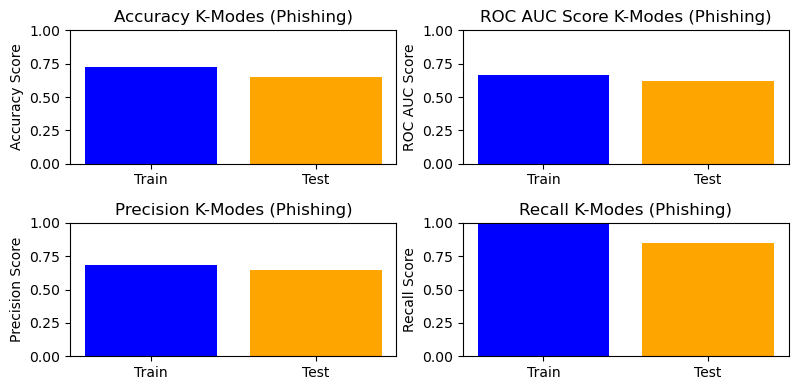

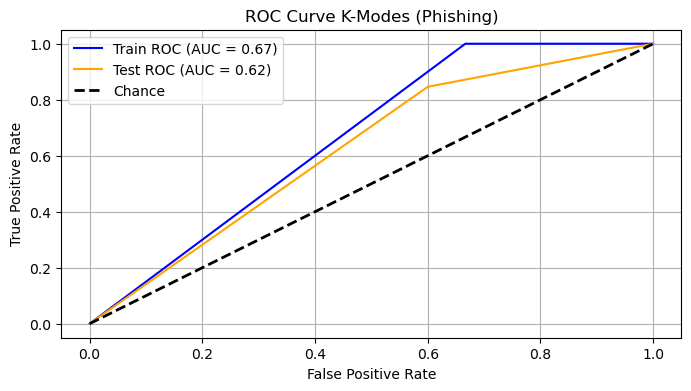

CPU times: user 764 ms, sys: 22.8 ms, total: 786 ms
Wall time: 282 ms


In [71]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy_kmodes, test_accuracy_kmodes], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy K-Modes (Phishing)')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc_kmodes, test_roc_auc_kmodes], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score K-Modes (Phishing)')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision_kmodes, test_precision_kmodes], color=['blue', 'orange'])
ax[1, 0].set_title('Precision K-Modes (Phishing)')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall_kmodes, test_recall_kmodes], color=['blue', 'orange'])
ax[1, 1].set_title('Recall K-Modes (Phishing)')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/phishing-nn-kmodes-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr_kmodes, train_tpr_kmodes, _ = roc_curve(train_y_kmodes, train_predictions_kmodes)
test_fpr_kmodes, test_tpr_kmodes, _ = roc_curve(test_y_kmodes, test_predictions_kmodes)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr_kmodes, train_tpr_kmodes, label=f'Train ROC (AUC = {auc(train_fpr_kmodes, train_tpr_kmodes):.2f})', color='blue')
plt.plot(test_fpr_kmodes, test_tpr_kmodes, label=f'Test ROC (AUC = {auc(test_fpr_kmodes, test_tpr_kmodes):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve K-Modes (Phishing)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-nn-kmodes-roc-curve')
plt.show()

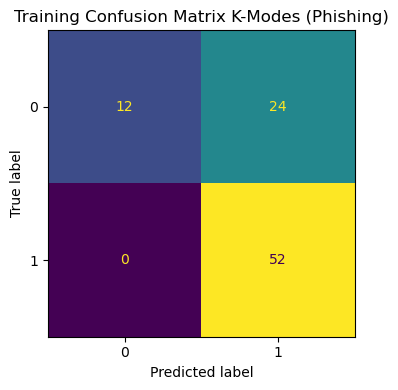

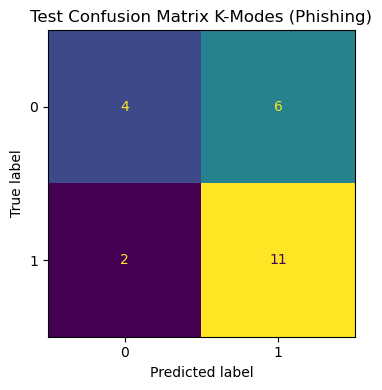

CPU times: user 361 ms, sys: 14.7 ms, total: 376 ms
Wall time: 145 ms


In [72]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm_kmodes = confusion_matrix(train_y_kmodes, train_predictions_kmodes)
ConfusionMatrixDisplay(train_cm_kmodes).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix K-Modes (Phishing)")
plt.tight_layout()
plt.savefig('../images/phishing-nn-kmodes-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm_kmodes = confusion_matrix(test_y_kmodes, test_predictions_kmodes)
ConfusionMatrixDisplay(test_cm_kmodes).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix K-Modes (Phishing)')
plt.tight_layout()
plt.savefig('../images/phishing-nn-kmodes-testing-cm.png')
plt.show()

Training progress:   0%|                                                                                                                                                                                                                                       | 0/10 [00:00<?, ?it/s]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

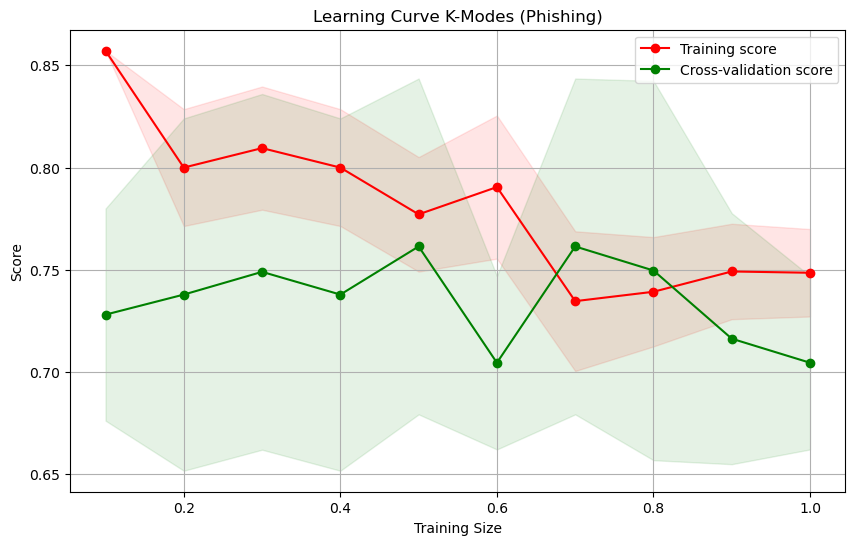

CPU times: user 1.33 s, sys: 906 ms, total: 2.23 s
Wall time: 1.18 s


In [73]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes_kmodes = np.linspace(0.1, 1.0, 10)
train_sizes_kmodes, train_scores_kmodes, test_scores_kmodes = learning_curve_with_progress(neural_net_kmodes, train_X_kmodes, train_y_kmodes, cv=5, scoring='accuracy', train_sizes=train_sizes_kmodes)

train_scores_mean_kmodes = np.mean(train_scores_kmodes, axis=1)
train_scores_std_kmodes = np.std(train_scores_kmodes, axis=1)
test_scores_mean_kmodes = np.mean(test_scores_kmodes, axis=1)
test_scores_std_kmodes = np.std(test_scores_kmodes, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes_kmodes, train_scores_mean_kmodes - train_scores_std_kmodes,
                 train_scores_mean_kmodes + train_scores_std_kmodes, alpha=0.1, color='r')
plt.fill_between(train_sizes_kmodes, test_scores_mean_kmodes - test_scores_std_kmodes,
                 test_scores_mean_kmodes + test_scores_std_kmodes, alpha=0.1, color='g')

plt.plot(train_sizes_kmodes, train_scores_mean_kmodes, 'o-', color='r', label='Training score')
plt.plot(train_sizes_kmodes, test_scores_mean_kmodes, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve K-Modes (Phishing)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-nn-kmodes-learning-curve-training-size.png')
plt.show()

In [109]:
def validation_curve_with_time(estimator, X, y, param_name, param_range, cv, scoring):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1)
    
    train_times = []
    for param in param_range:
        start_time = time.time()
        estimator.set_params(**{param_name: param})
        estimator.fit(X, y)
        train_times.append(time.time() - start_time)
    
    return train_scores, test_scores, train_times

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

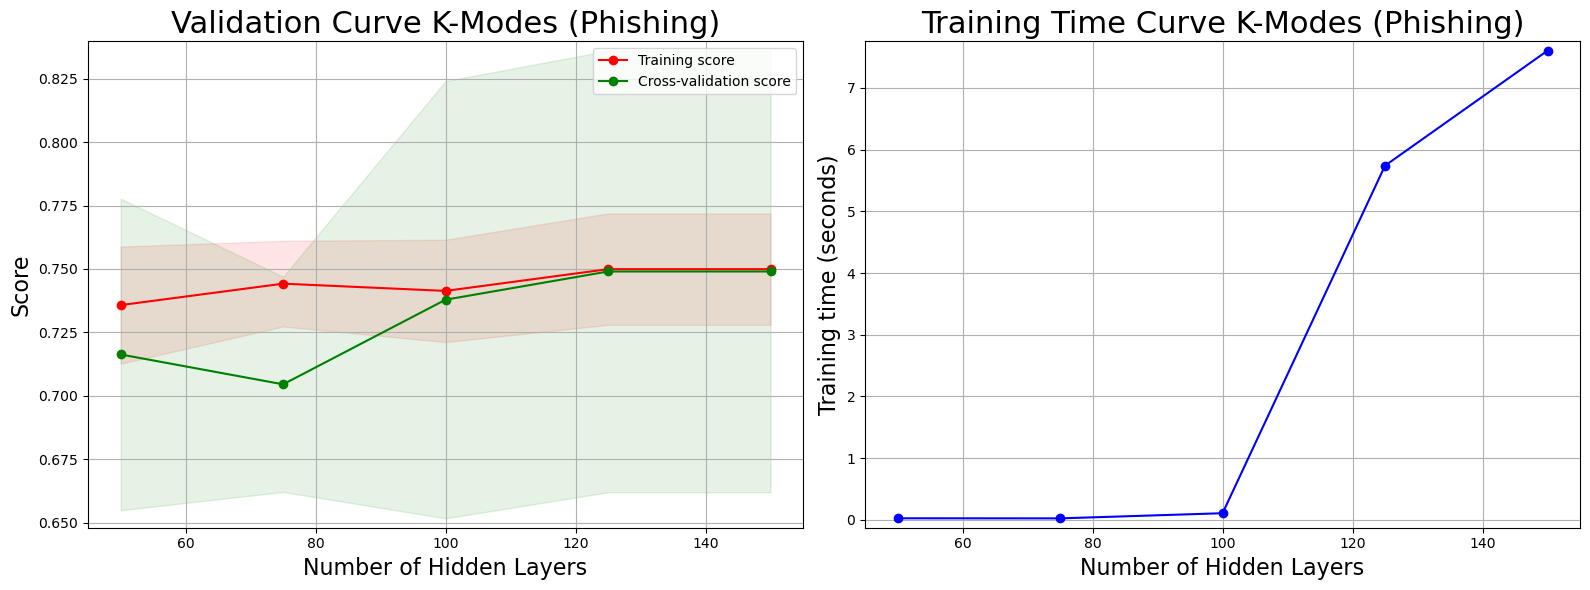

In [115]:
param_range = [50, 75, 100, 125, 150]
train_scores, test_scores, train_times = validation_curve_with_time(
    MLPClassifier(), train_X_kmodes, train_y_kmodes, "hidden_layer_sizes", 
    param_range, cv=5, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation curve
ax1.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
ax1.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax1.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax1.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.set_title('Validation Curve K-Modes (Phishing)', fontsize=22)
ax1.set_xlabel('Number of Hidden Layers', fontsize=16)
ax1.set_ylabel('Score', fontsize=16)
ax1.legend(loc="best")
ax1.grid()

# Adjust y-axis limits for validation curve
y_min = min(min(train_scores_mean - train_scores_std), min(test_scores_mean - test_scores_std))
y_max = max(max(train_scores_mean + train_scores_std), max(test_scores_mean + test_scores_std))
ax1.set_ylim(y_min - 0.02 * (y_max - y_min), y_max + 0.02 * (y_max - y_min))

# Time curve
ax2.plot(param_range, train_times, 'o-', color='b')
ax2.set_title('Training Time Curve K-Modes (Phishing)', fontsize=22)
ax2.set_xlabel('Number of Hidden Layers', fontsize=16)
ax2.set_ylabel('Training time (seconds)', fontsize=16)
ax2.grid()

# Adjust y-axis limits for time curve
y_min_time = min(train_times)
y_max_time = max(train_times)
ax2.set_ylim(y_min_time - 0.02 * (y_max_time - y_min_time), y_max_time + 0.02 * (y_max_time - y_min_time))

# Adjust layout and save
plt.tight_layout()
plt.savefig('../images/phishing-nn-kmodes-validation-and-time-curves.png', bbox_inches='tight', pad_inches=0.1)
plt.show()
plt.close()

Validation progress:   0%|                                                                                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Opti

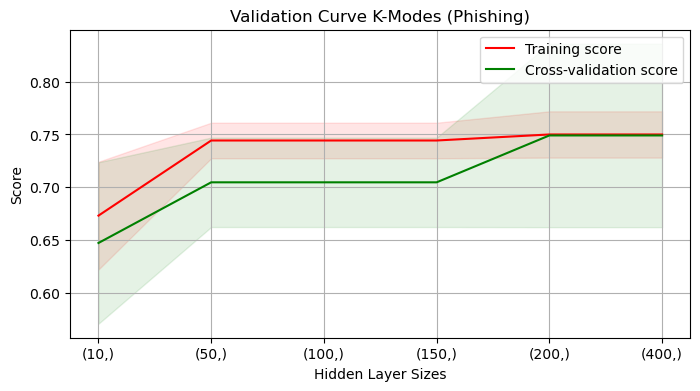

CPU times: user 276 ms, sys: 13.4 ms, total: 289 ms
Wall time: 382 ms


In [81]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X_kmodes, train_y_kmodes, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve K-Modes (Phishing)")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn-kmodes-validation-curve-hidden-layer-sizes-2.png')
plt.show()

In [ ]:
%%time
# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X_kmodes, train_y_kmodes, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve K-Modes (Phishing)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn-kmodes-validation-curve-alpha.png')
plt.show()

In [ ]:
train_sizes, train_scores, test_scores, train_times = learning_curve_with_time(
    neural_net_kmeans, train_X_kmeans, train_y_kmeans, cv=5, scoring='accuracy', 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 10))

# Learning curve
plt.subplot(2, 1, 1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title('Learning Curve K-Means (Default Payments)')
plt.xlabel('Number of training examples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()

# Time curve
plt.subplot(2, 1, 2)
plt.plot(train_sizes, train_times, 'o-')
plt.title('Training Time Curve')
plt.xlabel('Number of training examples')
plt.ylabel('Training time (seconds)')
plt.grid()

plt.tight_layout()
plt.savefig('../images/default-payments-nn-kmeans-learning-curve-with-time.png')
plt.show()

In [ ]:
%%time
# Perform 10-fold cross-validation
cv_scores_kmodes = cross_val_score(neural_net_kmodes, train_X_kmodes, train_y_kmodes, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores_kmodes)
print("Mean cross-validation score:", cv_scores_kmodes.mean())

# Write cross-validation scores to a text file
with open('../results/phishing-nn-kmodes-cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores_kmodes) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores_kmodes.mean()) + "\n")

In [ ]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores_kmodes, marker='o', linestyle='--')
plt.title('Cross-Validation Scores K-Modes (Phishing)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.75, .85])
plt.grid(True)
plt.savefig('../images/phishing-nn-kmodes-cross-validation-scores.png')
plt.show()

In [ ]:
%%time
y_pred_kmodes = cross_val_predict(neural_net_kmodes, train_X_kmodes, train_y_kmodes, cv=10)

report = classification_report(train_y_kmodes, y_pred_kmodes)
print(report)

with open('../results/phishing-nn-kmodes-classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y_kmodes, y_pred_kmodes, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve K-Modes (Phishing)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-nn-kmodes-roc-curve-fpr.png')
plt.show()

In [ ]:
%%time
best_mlp_kmodes = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=100,
    solver='adam'
)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp_kmodes, train_X_kmodes, train_y_kmodes, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve K-Modes (Phishing)')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn-kmodes-best-nn-training-vs-test-set')
plt.show()
# Write to a text file
with open('../results/phishing-nn-kmodes-test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report_kmodes + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm) + "\n")

### Expectation Maximization

In [83]:
train_X_em = pd.DataFrame(gmm_labels)
train_y_em = pd.Series(train_y)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index_em, test_index_em in split.split(train_X_em, train_y_em):
    strat_train_set_em = train_X_em.iloc[train_index_em]
    strat_test_set_em = train_X_em.iloc[test_index_em]
    strat_train_labels_em = train_y_em.iloc[train_index_em]
    strat_test_labels_em = train_y_em.iloc[test_index_em]

train_X_em = strat_train_set_em
test_X_em = strat_test_set_em
train_y_em = strat_train_labels_em
test_y_em = strat_test_labels_em

In [84]:
neural_net_em = MLPClassifier()
neural_net_em.fit(train_X_em, train_y_em)

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [29]:
%%time
# Evaluate on training data
train_predictions_em = neural_net_em.predict(train_X_em)
train_accuracy_em = accuracy_score(train_y_em, train_predictions_em)
train_roc_auc_em = roc_auc_score(train_y_em, train_predictions_em)
train_precision_em = precision_score(train_y_em, train_predictions_em)
train_recall_em = recall_score(train_y_em, train_predictions_em)
train_f1_em = f1_score(train_y_em, train_predictions_em)

print("Training Accuracy Expectation Maximization:", train_accuracy_em)
print("Training ROC AUC Score Expectation Maximization:", train_roc_auc_em)
print("Training Precision Expectation Maximization:", train_precision_em)
print("Training Recall Expectation Maximization:", train_recall_em)
print("Training F1 Score Expectation Maximization:", train_f1_em)
train_report_em = classification_report(train_y_em, train_predictions_em)
print(train_report_em)

# Write to a text file
with open('../results/phishing-nn-em-training_metrics_report.txt', 'w') as file:
    file.write("Training Accuracy Expectation Maximization: " + str(train_accuracy_em) + "\n")
    file.write("Training ROC AUC Score Expectation Maximization: " + str(train_roc_auc_em) + "\n")
    file.write("Training Precision Expectation Maximization: " + str(train_precision_em) + "\n")
    file.write("Training Recall Expectation Maximization: " + str(train_recall_em) + "\n")
    file.write("Training F1 Score Expectation Maximization: " + str(train_f1_em) + "\n")
    file.write("\nClassification Report Expectation Maximization:\n")
    file.write(train_report_em + "\n")

Training Accuracy Expectation Maximization: 0.6278280542986425
Training ROC AUC Score Expectation Maximization: 0.5915520833333333
Training Precision Expectation Maximization: 0.6226685796269728
Training Recall Expectation Maximization: 0.868
Training F1 Score Expectation Maximization: 0.7251461988304093
              precision    recall  f1-score   support

          -1       0.65      0.32      0.42       384
           1       0.62      0.87      0.73       500

    accuracy                           0.63       884
   macro avg       0.63      0.59      0.57       884
weighted avg       0.63      0.63      0.59       884

CPU times: user 143 ms, sys: 116 ms, total: 259 ms
Wall time: 37 ms


In [30]:
%%time
# Evaluate testing data
test_predictions_em = neural_net_em.predict(test_X_em)
test_accuracy_em = accuracy_score(test_y_em, test_predictions_em)
test_roc_auc_em = roc_auc_score(test_y_em, test_predictions_em)
test_precision_em = precision_score(test_y_em, test_predictions_em)
test_recall_em = recall_score(test_y_em, test_predictions_em)
test_f1_em = f1_score(test_y_em, test_predictions_em)

print("Testing Accuracy Expectation Maximization:", test_accuracy_em)
print("Testing ROC AUC Score Expectation Maximization:", test_roc_auc_em)
print("Testing Precision Expectation Maximization:", test_precision_em)
print("Testing Recall Expectation Maximization:", test_recall_em)
print("Testing F1 Score Expectation Maximization:", test_f1_em)
test_report_em = classification_report(test_y_em, test_predictions_em)
print(test_report_em)

# Write to a text file
with open('../results/phishing-nn-em-testing_metrics_report.txt', 'w') as file:
    file.write("Testing Accuracy Expectation Maximization: " + str(test_accuracy_em) + "\n")
    file.write("Testing ROC AUC Score Expectation Maximization: " + str(test_roc_auc_em) + "\n")
    file.write("Testing Precision Expectation Maximization: " + str(test_precision_em) + "\n")
    file.write("Testing Recall Expectation Maximization: " + str(test_recall_em) + "\n")
    file.write("Testing F1 Score Expectation Maximization: " + str(test_f1_em) + "\n")
    file.write("\nClassification Report Expectation Maximization:\n")
    file.write(test_report_em + "\n")

Testing Accuracy Expectation Maximization: 0.6306306306306306
Testing ROC AUC Score Expectation Maximization: 0.5969484536082474
Testing Precision Expectation Maximization: 0.6242774566473989
Testing Recall Expectation Maximization: 0.864
Testing F1 Score Expectation Maximization: 0.7248322147651006
              precision    recall  f1-score   support

          -1       0.65      0.33      0.44        97
           1       0.62      0.86      0.72       125

    accuracy                           0.63       222
   macro avg       0.64      0.60      0.58       222
weighted avg       0.64      0.63      0.60       222

CPU times: user 149 ms, sys: 107 ms, total: 257 ms
Wall time: 36.6 ms


In [ ]:
%%time
fig, ax = plt.subplots(2, 2, figsize=(8, 4))

# Accuracy
ax[0, 0].bar(['Train', 'Test'], [train_accuracy_em, test_accuracy_em], color=['blue', 'orange'])
ax[0, 0].set_title('Accuracy Expectation Maximization (Phishing)')
ax[0, 0].set_ylim([0, 1])
ax[0, 0].set_ylabel('Accuracy Score')

# ROC AUC Score
ax[0, 1].bar(['Train', 'Test'], [train_roc_auc_em, test_roc_auc_em], color=['blue', 'orange'])
ax[0, 1].set_title('ROC AUC Score Expectation Maximization (Phishing)')
ax[0, 1].set_ylim([0, 1])
ax[0, 1].set_ylabel('ROC AUC Score')

# Precision
ax[1, 0].bar(['Train', 'Test'], [train_precision_em, test_precision_em], color=['blue', 'orange'])
ax[1, 0].set_title('Precision Expectation Maximization (Phishing)')
ax[1, 0].set_ylim([0, 1])
ax[1, 0].set_ylabel('Precision Score')

# Recall
ax[1, 1].bar(['Train', 'Test'], [train_recall_em, test_recall_em], color=['blue', 'orange'])
ax[1, 1].set_title('Recall Expectation Maximization (Phishing)')
ax[1, 1].set_ylim([0, 1])
ax[1, 1].set_ylabel('Recall Score')

plt.tight_layout()
fig.savefig('../images/phishing-nn-em-metrics-comparison.png')
plt.show()

# Plotting  ROC Curves
train_fpr_em, train_tpr_em, _ = roc_curve(train_y_em, train_predictions_em)
test_fpr_em, test_tpr_em, _ = roc_curve(test_y_em, test_predictions_em)

plt.figure(figsize=(8, 4))
plt.plot(train_fpr_em, train_tpr_em, label=f'Train ROC (AUC = {auc(train_fpr_em, train_tpr_em):.2f})', color='blue')
plt.plot(test_fpr_em, test_tpr_em, label=f'Test ROC (AUC = {auc(test_fp_em, test_tpr_em):.2f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve Expectation Maximization (Phishing)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-nn-em-roc-curve')
plt.show()

In [ ]:
%%time
# Plot and save Training Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
train_cm_em = confusion_matrix(train_y_em, train_predictions_em)
ConfusionMatrixDisplay(train_cm_em).plot(ax=ax, colorbar=False)
ax.set_title("Training Confusion Matrix Expectation Maximization (Phishing")
plt.tight_layout()
plt.savefig('../images/phishing-nn-kmodes-training-cm.png')
plt.show()

# Plot and save Test Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 4))
test_cm_em = confusion_matrix(test_y_em, test_predictions_em)
ConfusionMatrixDisplay(test_cm_em).plot(ax=ax, colorbar=False)
ax.set_title('Test Confusion Matrix Expectation Maximization (Phishing)')
plt.tight_layout()
plt.savefig('../images/phishing-nn-em-testing-cm.png')
plt.show()

In [103]:
def validation_curve_with_time(estimator, X, y, param_name, param_range, cv, scoring):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, scoring=scoring, n_jobs=-1)
    
    train_times = []
    for param in param_range:
        start_time = time.time()
        estimator.set_params(**{param_name: param})
        estimator.fit(X, y)
        train_times.append(time.time() - start_time)
    
    return train_scores, test_scores, train_times

/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimize

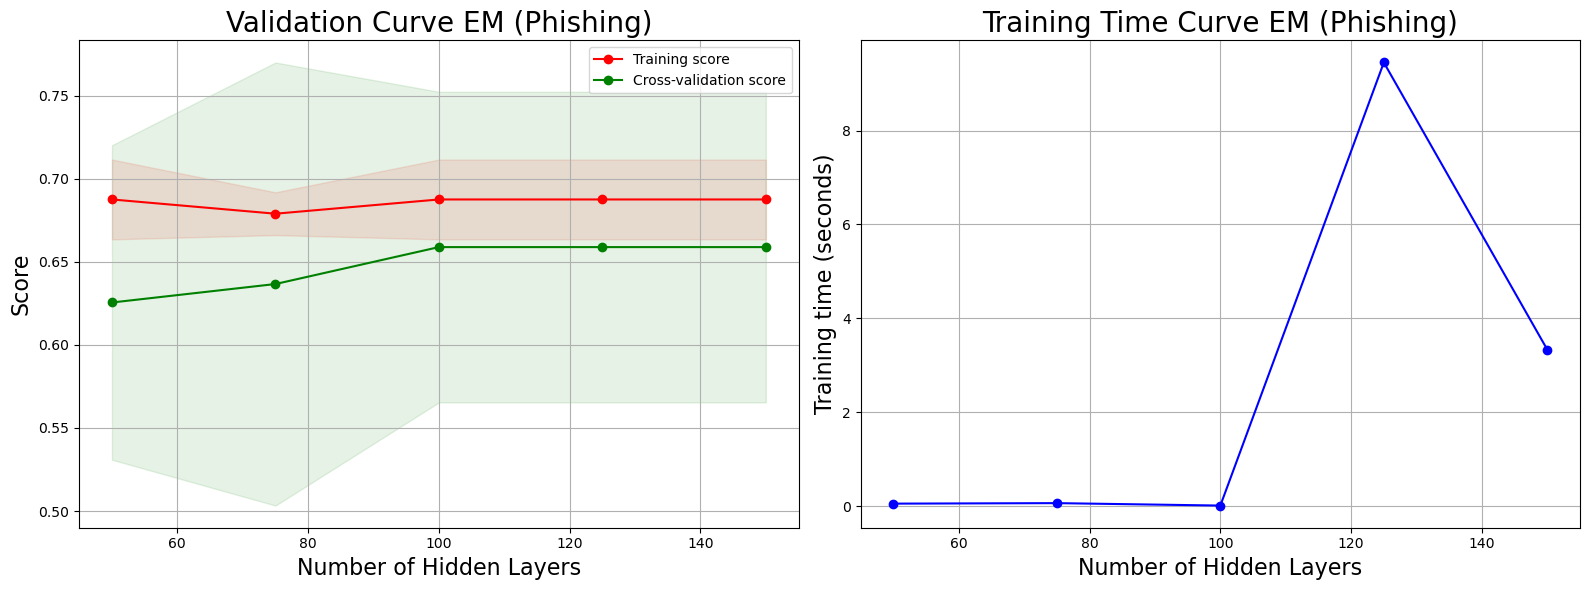

arnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/xavierelon/miniconda3/envs/unsupervised_learning/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stoch

In [116]:
param_range = [50, 75, 100, 125, 150]
train_scores, test_scores, train_times = validation_curve_with_time(
    MLPClassifier(), train_X_em, train_y_em, "hidden_layer_sizes", 
    param_range, cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation curve
ax1.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
ax1.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax1.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
ax1.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
ax1.set_title('Validation Curve EM (Phishing)', fontsize=20)
ax1.set_xlabel('Number of Hidden Layers', fontsize=16)
ax1.set_ylabel('Score', fontsize=16)
ax1.legend(loc="best")
ax1.grid()

# Time curve
ax2.plot(param_range, train_times, 'o-', color='b')
ax2.set_title('Training Time Curve EM (Phishing)', fontsize=20)
ax2.set_xlabel('Number of Hidden Layers', fontsize=16)
ax2.set_ylabel('Training time (seconds)', fontsize=16)
ax2.grid()

plt.tight_layout()
plt.savefig('../images/phishing-nn-em-validation-and-time-curves.png')
plt.show()
plt.close()

In [ ]:
%%time
# Create a wrapper function for learning_curve to show progress
def learning_curve_with_progress(estimator, X, y, cv, scoring, train_sizes):
    all_train_scores = []
    all_test_scores = []
    for train_size in tqdm(train_sizes, desc='Training progress'):
        _, train_scores, test_scores = learning_curve(estimator, X, y, train_sizes=[train_size], cv=cv, scoring=scoring)
        all_train_scores.append(train_scores)
        all_test_scores.append(test_scores)
    return train_sizes, np.array(all_train_scores).squeeze(), np.array(all_test_scores).squeeze()

train_sizes_em = np.linspace(0.1, 1.0, 10)
train_sizes_em, train_scores_em, test_scores_em = learning_curve_with_progress(neural_net_em, train_X_em, train_y_em, cv=5, scoring='accuracy', train_sizes=train_sizes_kmodes)

train_scores_mean_em = np.mean(train_scores_em, axis=1)
train_scores_std_em = np.std(train_scores_em, axis=1)
test_scores_mean_em = np.mean(test_scores_em, axis=1)
test_scores_std_em = np.std(test_scores_em, axis=1)

plt.figure(figsize=(10, 6))

plt.fill_between(train_sizes_em, train_scores_mean_em - train_scores_std_em,
                 train_scores_mean_em + train_scores_std_em, alpha=0.1, color='r')
plt.fill_between(train_sizes_em, test_scores_mean_em - test_scores_std_em,
                 test_scores_mean_em + test_scores_std_em, alpha=0.1, color='g')

plt.plot(train_sizes_em, train_scores_mean__em, 'o-', color='r', label='Training score')
plt.plot(train_sizes_em, test_scores_mean_em, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curve Expectation Maximization (Phishing)')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-nn-em-learning-curve-training-size.png')
plt.show()

In [ ]:
%%time
param_range = [50, 75, 100]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

train_scores, test_scores = validation_curve_with_progress(MLPClassifier(), train_X_em, train_y_em, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring='accuracy', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, 'o-', color='r', label="Training score")
plt.plot(param_range, test_scores_mean, 'o-', color='g', label="Cross-validation score")

plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color='g')

plt.title('Validation Curve Expectation Maximization (Phishing)')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()
plt.savefig('../images/phishing-nn-em-validation-curve-hidden-layers.png')
plt.show()

In [ ]:
%%time
# Define the range for the hyperparameter hidden_layer_sizes
param_range = [(10,), (50,), (100,), (150,), (200,), (400,)]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(random_state=42), train_X_em, train_y_em, param_name="hidden_layer_sizes", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot([str(x) for x in param_range], train_scores_mean, label="Training score", color="r")
plt.plot([str(x) for x in param_range], test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between([str(x) for x in param_range], train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between([str(x) for x in param_range], test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve Expectation Maximization (Phishing)")
plt.xlabel("Hidden Layer Sizes")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn-em-validation-curve-hidden-layer-sizes-2.png')
plt.show()

In [ ]:
%%time
# Define the range for the hyperparameter alpha
param_range = [0.0001, 0.001, 0.01, 0.1, 1]

# Function to calculate validation curve with progress bar
def validation_curve_with_progress(estimator, X, y, param_name, param_range, cv, scoring, n_jobs):
    train_scores = []
    test_scores = []
    for param in tqdm(param_range, desc='Validation progress'):
        train_score, test_score = validation_curve(estimator, X, y, param_name=param_name, param_range=[param], cv=cv, scoring=scoring, n_jobs=n_jobs)
        train_scores.append(train_score)
        test_scores.append(test_score)
    return np.array(train_scores).squeeze(), np.array(test_scores).squeeze()

# Calculate validation curve data
train_scores, test_scores = validation_curve_with_progress(
    MLPClassifier(hidden_layer_sizes=(100,), random_state=42), train_X_em, train_y_em, param_name="alpha", param_range=param_range, cv=5, scoring="accuracy", n_jobs=-1
)

# Calculate mean and standard deviation for training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot validation curve
plt.figure(figsize=(8, 4))
plt.plot(param_range, train_scores_mean, label="Training score", color="r")
plt.plot(param_range, test_scores_mean, label="Cross-validation score", color="g")

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.title("Validation Curve Expectation Maximization (Phishing)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.xscale('log')  # Use a logarithmic scale for alpha
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn-em-validation-curve-alpha.png')
plt.show()

In [ ]:
%%time
# Perform 10-fold cross-validation
cv_scores_em = cross_val_score(neural_net_em, train_X_em, train_y_em, cv=10, scoring='accuracy')

# Print cross-validation scores
print("Cross-validation scores:", cv_scores_em)
print("Mean cross-validation score:", cv_scores_em.mean())

# Write cross-validation scores to a text file
with open('../results/phishing-nn-em-cross_validation_scores.txt', 'w') as file:
    file.write("Cross-validation scores: " + np.array2string(cv_scores) + "\n")
    file.write("Mean cross-validation score: " + str(cv_scores.mean()) + "\n")

In [ ]:
# Plot cross-validation scores
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), cv_scores, marker='o', linestyle='--')
plt.title('Cross-Validation Scores Expectation Maximization (Phishing)')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0.75, .85])
plt.grid(True)
plt.savefig('../images/phishing-nn-em-cross-validation-scores.png')
plt.show()

In [ ]:
%%time
y_pred_em = cross_val_predict(neural_net_em, train_X_em, train_y_em, cv=10)

report = classification_report(train_y_em, y_pred_em)
print(report)

with open('../results/phishing-nn-em-classification_report.txt', 'w') as file:
    file.write(report)
    
fpr, tpr, thresholds = roc_curve(train_y, y_pred, pos_label=1)
plt.figure(figsize=(8, 4))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')
plt.title('ROC Curve Expectation Maximization (Phishing)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig('../images/phishing-nn-em-roc-curve-fpr.png')
plt.show()

In [ ]:
%%time
best_mlp_em = MLPClassifier(
    activation='relu',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate='adaptive',
    max_iter=100,
    solver='adam'
)

# Assuming best_mlp, train_X, train_y are already defined
train_sizes, train_scores, test_scores = learning_curve(
    best_mlp_em, train_X_em, train_y_em, cv=5, scoring='f1_weighted',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

# Calculate mean and standard deviation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(8, 4))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

plt.title('F1 Weighted Score Learning Curve Expectation Maximization (Phishing)')
plt.xlabel('Number of Training Instances Used')
plt.ylabel('Score')
plt.legend(loc="best")
plt.grid()
plt.savefig('../images/phishing-nn-em-best-nn-training-vs-test-set')
plt.show()
# Write to a text file
with open('../results/phishing-nn-em-test_classification_results.txt', 'w') as file:
    file.write("Classification Report:\n")
    file.write(test_report + "\n")
    file.write("Confusion Matrix:\n")
    file.write(np.array2string(test_cm) + "\n")

In [81]:
end = time.perf_counter()
print("Time taken: in min", (end - start)/60)

Time taken: in min 607.3838323395835
